# Human to machine date translation

## Imports

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook
import random
import matplotlib.pyplot as plt
from pylab import rcParams
import os
import numpy as np
import matplotlib

In [3]:
#for now there is some problem with cuda so only cpu versio is working on
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

## Load data

In [4]:
PATH = os.path.join('human-machine.csv')

df = pd.read_csv(PATH, index_col=0)

df

,human,machine
0,friday october 20 1995,1995-10-20
1,19 may 2011,2011-05-19
2,monday december 19 1994,1994-12-19
3,saturday june 22 1991,1991-06-22
4,november 4 1999,1999-11-04
...,...,...
9995,july 16 1980,1980-07-16
9996,friday august 11 1995,1995-08-11
9997,august 16 2015,2015-08-16
9998,jul 2 1980,1980-07-02


## Prepare data for the training


In [5]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 30

### Computers don't understand letters, so we need numbers

In [6]:
class CharDict:
    def __init__(self):
        self.char2index = {}
        self.char2count = {}
        self.index2char = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_chars = 2

    def addSentence(self, sentence):
        for c in sentence:
            self.addChar(c)

    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

In [7]:
def prepare_data():
    df = pd.read_csv(PATH)
    human = df["human"].values
    machine = df["machine"].values
    pairs = []
    for i in range(len(human)):
        pairs.append([human[i], machine[i]])

    input_lang = CharDict()
    output_lang = CharDict()
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    return input_lang, output_lang, pairs

In [8]:
input_lang, output_lang, pairs = prepare_data()

print(f"Input char indices: {input_lang.char2index}")
print()
print(f"Example pair: {pairs[2137]}")

Input char indices: {'f': 2, 'r': 3, 'i': 4, 'd': 5, 'a': 6, 'y': 7, ' ': 8, 'o': 9, 'c': 10, 't': 11, 'b': 12, 'e': 13, '2': 14, '0': 15, '1': 16, '9': 17, '5': 18, 'm': 19, 'n': 20, '4': 21, 's': 22, 'u': 23, 'j': 24, 'v': 25, 'w': 26, '7': 27, 'l': 28, '8': 29, 'h': 30, '6': 31, 'p': 32, '3': 33, '.': 34, '/': 35, 'g': 36}

Example pair: ['november 27 1999', '1999-11-27']


In [9]:
def indexes_from_sentence(lang, sentence):
    return [lang.char2index[char] for char in sentence]


def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1)).to(device)
    # if USE_CUDA: var = var.cuda()
    return var


def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [10]:
pair = ['november 27 1999', '1999-11-27']

print(f"Human input {pair[0]}")
print(f"Machine output {pair[1]}")

input_variable, target_variable = variables_from_pair(pair)

print(f"Real input length: {len(pair[0])}, parsed input shhape: {input_variable.shape}")
print(f"Real output length: {len(pair[1])}, parsed input shhape: {target_variable.shape}")

print()

print(f"Parsed human input {input_variable}")
print(f"Parsed machine output {target_variable}")

Human input november 27 1999
Machine output 1999-11-27
Real input length: 16, parsed input shhape: torch.Size([17, 1])
Real output length: 10, parsed input shhape: torch.Size([11, 1])

Parsed human input tensor([[20],
        [ 9],
        [25],
        [13],
        [19],
        [12],
        [13],
        [ 3],
        [ 8],
        [14],
        [27],
        [ 8],
        [16],
        [17],
        [17],
        [17],
        [ 1]])
Parsed machine output tensor([[ 2],
        [ 3],
        [ 3],
        [ 3],
        [ 5],
        [ 2],
        [ 2],
        [ 5],
        [ 7],
        [10],
        [ 1]])


## Define the model


<img src="images/seq2seq.png"/>

1. Embed
2. Encode
3. Attend
4. Predict


### Encoder

<img src="images/encoder-network.png"/>

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Example usage

In [12]:
print(f"Number of chars in input data: {input_lang.n_chars}")

encoder = EncoderRNN(input_lang.n_chars, hidden_size=64).to(device)

hidden = encoder.init_hidden()

print(f"Hidden state: {hidden}")

output, hidden = encoder(torch.tensor(21), hidden)

print(f"Output shape: {output.shape}")
print(f"Hidden state shape: {hidden.shape}")


print(f"Output: {output}")
print(f"Hidden state: {hidden}")

Number of chars in input data: 37
Hidden state: tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Output shape: torch.Size([1, 1, 64])
Hidden state shape: torch.Size([1, 1, 64])
Output: tensor([[[-0.0478, -0.5431,  0.0997, -0.2324,  0.0138,  0.1760, -0.0274,
          -0.0999, -0.0684, -0.1663,  0.2475,  0.0884, -0.3003, -0.2772,
          -0.2035, -0.1211,  0.2084,  0.3077,  0.4153,  0.2399,  0.3368,
           0.1871, -0.1179, -0.1679,  0.0261,  0.1721,  0.0880, -0.1811,
           0.1808,  0.0879, -0.0167,  0.0511,  0.0214, -0.1042,  0.0921,
          -0.0821, -0.5229, -0.0615, -0.3729, -0.2019,  0.2015,  0.0625,
          -0.0060,  0.4505, -0.1952,  0.0985, -0.2364, -0.0105,  0.2095,
          -0.6425,  0.0748,  0.1998, -0.0160,  0.0223, -0.4261, 

### Decoder

Example decoder in Encoder-Decoder architecture <b> WE DONT USE IT</b>, we will use Attention decoder instead. This one is only to introduce the concept of decoder.

<img src="images/decoder-network.png"/>

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Example usage

In [14]:
print(f"Number of chars in target data: {output_lang.n_chars}")


decoder = DecoderRNN(64, output_lang.n_chars).to(device)

# hidden = decoder.init_hidden()

output, hidden = decoder(torch.tensor([[SOS_token]], device=device), hidden)

print(f"Output shape: {output.shape}")
print(f"Hidden state shape: {hidden.shape}")


print(f"Output: {output}")
print(f"Hidden state: {hidden}")


Number of chars in target data: 13
Output shape: torch.Size([1, 13])
Hidden state shape: torch.Size([1, 1, 64])
Output: tensor([[-2.5416, -2.6538, -2.7066, -2.8975, -2.5685, -2.6640, -2.5171, -2.4762,
         -2.6472, -2.6047, -2.4126, -2.2777, -2.5134]],
       grad_fn=<LogSoftmaxBackward>)
Hidden state: tensor([[[ 0.0463, -0.0412, -0.1089, -0.0750, -0.2551,  0.2022,  0.1875,
          -0.1433, -0.0948,  0.1825, -0.0044,  0.0853, -0.0753,  0.0347,
          -0.0101, -0.0502,  0.0603,  0.0605,  0.1429,  0.1422,  0.0260,
           0.0137, -0.2558, -0.3137, -0.1612, -0.0095,  0.1899, -0.1191,
          -0.0381,  0.2819,  0.0628,  0.1220,  0.2648, -0.0064, -0.1064,
          -0.1815, -0.4039, -0.0181,  0.1713,  0.0944,  0.1834,  0.2286,
           0.1672,  0.1851, -0.1682,  0.2012, -0.1542, -0.1794,  0.0296,
          -0.6866, -0.0940,  0.1615,  0.1683,  0.0476, -0.0128,  0.1943,
           0.0385, -0.1504, -0.0153,  0.0608,  0.0928,  0.0461, -0.1079,
          -0.3438]]], grad_fn=<Stac

### Attention decoder

<img width=300px src="images/attention-decoder-network.png"/>

In [15]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Define the training hyperparamters

In [16]:
EPOCHS = 30_000
LEARNING_RATE = 0.005
HIDDEN_SIZE = 64
TEACHER_FORCING_RATIO = 0.5


## Define a training function

In [17]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for i in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[i], encoder_hidden)
        encoder_outputs[i] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < TEACHER_FORCING_RATIO else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target  as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

## Design a training loop

In [18]:
encoder = EncoderRNN(input_lang.n_chars, HIDDEN_SIZE).to(device)
decoder = AttentionDecoderRNN(HIDDEN_SIZE, output_lang.n_chars, dropout_p=0.1).to(device)


encoder_optimizer = optim.SGD(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=LEARNING_RATE)

criterion = nn.NLLLoss()

In [19]:
training_pairs = [variables_from_pair(random.choice(pairs))
                  for i in range(EPOCHS)]

In [20]:
losses = []

In [21]:
for epoch in tqdm_notebook(range(EPOCHS)):
    
    pair = training_pairs[epoch]
    input_tensor = pair[0]
    target_tensor = pair[1]
    

    
    loss = train(input_tensor, target_tensor, encoder,
             decoder, encoder_optimizer, decoder_optimizer, criterion)

    if epoch % 1000 == 0:
        print(f"Loss: {loss}")
    
    losses.append(loss)
    

/home/piotr/anaconda3/envs/pumapython/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


Loss: 2.5125999450683594
Loss: 1.1206715323708274
Loss: 0.8173559362238104
Loss: 0.5885919224132191
Loss: 0.5791624242609198
Loss: 0.8763106086037376
Loss: 0.6172269907864657
Loss: 0.49876928329467773
Loss: 0.22797547687183728
Loss: 0.22864588824185458
Loss: 0.3331551335074685
Loss: 0.3626427867195823
Loss: 0.18350672721862793
Loss: 0.05678801103071733
Loss: 0.3948114135048606
Loss: 0.14968870986591687
Loss: 0.059521160342476585
Loss: 0.05851893533359875
Loss: 0.1177993579344316
Loss: 1.9571045962246982
Loss: 0.014749405058947477
Loss: 0.021961576559326866
Loss: 0.007481871003454382
Loss: 0.19452922994440253
Loss: 0.06800693273544312
Loss: 0.16283817724748093
Loss: 0.7414084347811613
Loss: 0.030698407780040394
Loss: 0.00231440162116831
Loss: 0.04002220251343467



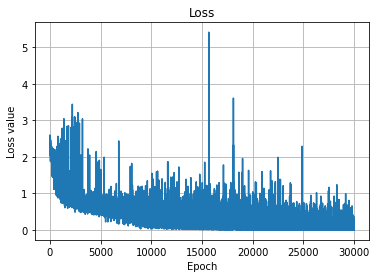

In [22]:
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.grid()
plt.show()

## Show predictions generated by a network

In [24]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    droput_value = decoder.dropout_p
    
    with torch.no_grad():
        decoder.dropout_p = 0.0
        
        input_tensor = variable_from_sentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for i in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[i],
                                                     encoder_hidden)
            encoder_outputs[i] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2char[topi.item()])

            decoder_input = topi.squeeze().detach()
            
        decoder.dropout_p = droput_value

        return decoded_words, decoder_attentions[:di + 1]

In [25]:
def visualize_attention(input_word, output_word, attentions):
    fig, ax = plt.subplots()
    im = ax.imshow(attentions.numpy())

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(input_word)))
    ax.set_yticks(np.arange(len(output_word)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(input_word)
    ax.set_yticklabels(output_word)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    output_word = "".join(output_word).replace("<EOS>", "")

    ax.set_title(f"Input: {input_word}, Prediction: {output_word}")
    fig.tight_layout()

    
    rcParams['figure.figsize'] = 10, 20
    plt.show()
    

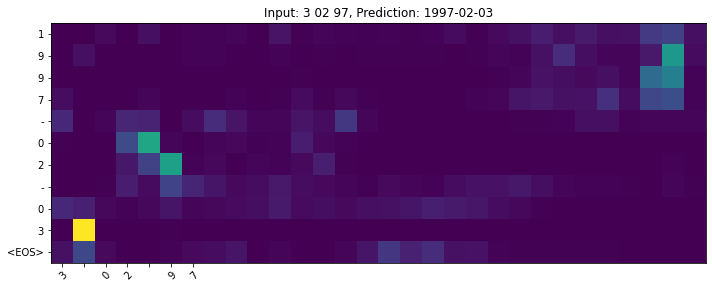

In [27]:
input_word = "3 02 97"

output_word, attentions = evaluate(
    encoder, decoder, input_word)

visualize_attention(input_word, output_word, attentions)
